<a href="https://colab.research.google.com/github/washmore1/PopulationHealthcareAnalytics/blob/main/DiabetesRiskScoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Diabetes Risk Scoring**

Using my generated healthcare database, I now want to create a diabetes-related risk scoring system that uses patient characteristics and the clinical data to assign a risk score to each patient.

In order to proceed with this, we must first define our factors and criteria:

| **Factor**               | **Data Source** | **Criteria**                                       | **Score** |
| ------------------------ | --------------- | -------------------------------------------------- | --------- |
| Age                      | `df_demo`       | Age ≥ 65 → +1                                      | 1         |
| Insurance Type           | `df_demo`       | Uninsured or Medicaid → +1                         | 1         |
| HbA1c                    | `df_labs`       | Most recent HbA1c ≥ 9.0 → +2; 7.5–8.9 → +1         | 1–2       |
| LDL Cholesterol          | `df_labs`       | Most recent LDL ≥ 160 → +1                         | 1         |
| Creatinine               | `df_labs`       | Most recent Creatinine ≥ 1.5 → +1                  | 1         |
| Complicated Diabetes     | `df_diag`       | Diagnosis code is `E11.2` or `E11.9` → +2          | 2         |
| Emergency Visits         | `df_visits`     | ≥2 Emergency visits → +1                           | 1         |
| Care Management Enrolled | `df_care`       | If enrolled in any care program → -1 (lowers risk) | -1        |


**Setup**

In [2]:
# Setup Installation and Importation
!pip install pandas numpy scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the CSV files into Colab
from google.colab import files
uploaded = files.upload()

Saving patient_demographics.csv to patient_demographics.csv
Saving visits.csv to visits.csv
Saving medications.csv to medications.csv
Saving lab_results.csv to lab_results.csv
Saving clinical_diagnoses.csv to clinical_diagnoses.csv
Saving care_management.csv to care_management.csv


In [5]:
# Read each csv file into it's own dataframe
df_demo = pd.read_csv('patient_demographics.csv')
df_diag = pd.read_csv('clinical_diagnoses.csv')
df_labs = pd.read_csv('lab_results.csv')
df_meds = pd.read_csv('medications.csv')
df_visits = pd.read_csv('visits.csv')
df_care = pd.read_csv('care_management.csv')

In [6]:
# verify successful import and preview data
print(f"Demographics data shape: {df_demo.shape}")
print(f"Diagnoses data shape: {df_diag.shape}")
print(f"Labs data shape: {df_labs.shape}")
print(f"Medications data shape: {df_meds.shape}")
print(f"Visits data shape: {df_visits.shape}")
print(f"Care management data shape: {df_care.shape}")

Demographics data shape: (10000, 5)
Diagnoses data shape: (12988, 3)
Labs data shape: (40347, 4)
Medications data shape: (19867, 4)
Visits data shape: (64406, 4)
Care management data shape: (4025, 4)


**Preparing the Risk Dataframe**

In [8]:
# Creation of the risk dataframe
risk_df = df_demo[['Patient_ID', 'Age', 'Insurance_Type']].copy()
risk_df['Risk_Score'] = 0

# Add age-based risk
risk_df['Risk_Score'] += (risk_df['Age'] >= 65).astype(int)

# Add insurance-based risk
risk_df['Risk_Score'] += risk_df['Insurance_Type'].isin(['Uninsured', 'Medicaid']).astype(int)

**Grab the most recent lab values**

In [9]:
# Most recent lab values per patient and lab type
recent_labs = df_labs.sort_values('Lab_Date').groupby(['Patient_ID', 'Lab_Type']).last().reset_index()
pivot_labs = recent_labs.pivot(index='Patient_ID', columns='Lab_Type', values='Lab_Value').reset_index()
risk_df = risk_df.merge(pivot_labs, on='Patient_ID', how='left')


In [10]:
# Add HbA1c risk
# CRITERIA: HbA1c ≥ 9 → +2; 7.5–8.9 → +1
risk_df['Risk_Score'] += np.where(risk_df['HbA1c'] >= 9.0, 2,
                           np.where(risk_df['HbA1c'] >= 7.5, 1, 0))

In [11]:
# Add LDL and Creatinine risk
risk_df['Risk_Score'] += (risk_df['LDL Cholesterol'] >= 160).astype(int)
risk_df['Risk_Score'] += (risk_df['Creatinine'] >= 1.5).astype(int)

In [12]:
# Add Complication diagnosis risk
comp_patients = df_diag[df_diag['Diagnosis_Code'].isin(['E11.2', 'E11.9'])]['Patient_ID'].unique()
risk_df['Risk_Score'] += risk_df['Patient_ID'].isin(comp_patients).astype(int) * 2

In [13]:
# Add emergency visit risk
emergency_visits = df_visits[df_visits['Visit_Type'] == 'Emergency']
emergency_counts = emergency_visits.groupby('Patient_ID').size()
risk_df['Risk_Score'] += risk_df['Patient_ID'].map(lambda x: int(emergency_counts.get(x, 0) >= 2))

In [14]:
# subtract score for care management
enrolled_in_care = df_care['Patient_ID'].unique()
risk_df['Risk_Score'] -= risk_df['Patient_ID'].isin(enrolled_in_care).astype(int)

**Preview and Categorize Risk**

In [15]:
# Create risk category
def categorize(score):
    if score >= 5:
        return 'High'
    elif score >= 3:
        return 'Medium'
    else:
        return 'Low'

risk_df['Risk_Category'] = risk_df['Risk_Score'].apply(categorize)
risk_df[['Patient_ID', 'Risk_Score', 'Risk_Category']].head()

,Patient_ID,Risk_Score,Risk_Category
0,P000001,4,Medium
1,P000002,2,Low
2,P000003,5,High
3,P000004,1,Low
4,P000005,3,Medium


**Risk Distribution Visualization**

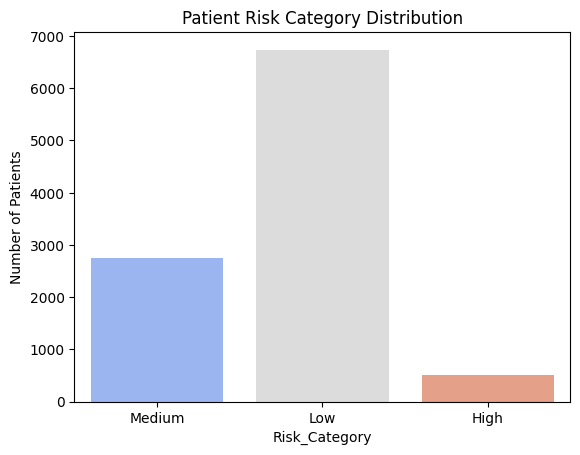

In [17]:
sns.countplot(data=risk_df, x='Risk_Category', hue='Risk_Category', palette='coolwarm', legend=False)
plt.title('Patient Risk Category Distribution')
plt.ylabel('Number of Patients')
plt.show()

**Save and Export to CSV**

In [18]:
risk_df.to_csv('diabetes_risk.csv', index=False)

In [19]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [21]:
!cp diabetes_risk.csv "/content/drive/My Drive/PythonHealthcareProject"